We test Fisher Score Matching on the two-moon task, a standard benchmark for simulation-based inference (see [Benchmarking Simulation-Based Inference](https://arxiv.org/abs/2101.04653)). In this case, the model is not decomposable, so we adopt an approach where a latent variable is introduced into the model to enable estimation of the Fisher score.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys 
import os
sys.path.append('/home/csui1/workspace/fsm/FisherScoreMatching')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
#torch 
import torch
import torch.nn as nn
from fsm.models import LinearGaussianModel
from fsm.plot_utils import downsample_scatter_plot,plot_vector_field
from fsm.regressor import FSM_Regressor
from fsm.tools import to_numpy,to_tensor

load the task

In [5]:
import sbibm

task = sbibm.get_task("two_moons") 
prior = task.get_prior()
simulator = task.get_simulator()

Introduce a latent variable and apply a perturbation to it. Then, generate observations based on the perturbed latent variable.

In [7]:
from sklearn.model_selection import train_test_split
dim = 2

all_prior = [[-1,1], [-1,1]]
all_prior = np.array(all_prior)

sample_size = 100000


thetas_latent = prior(num_samples=sample_size)

#perturb theta_tild 
epsilon_cov = np.diag((all_prior[:,1] - all_prior[:,0])/100)**2
latent_model = LinearGaussianModel(cov = epsilon_cov)
thetas, latent_score = latent_model.sample_and_score(thetas_latent)

x = simulator(thetas)

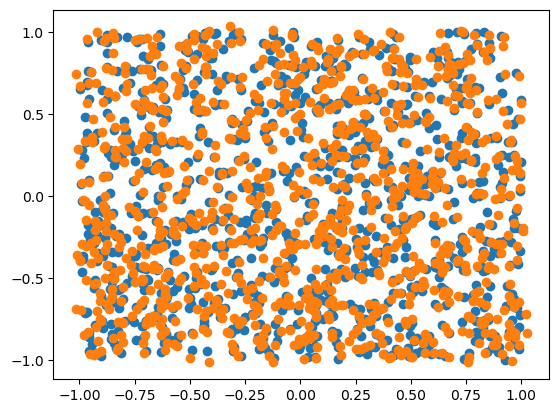

In [8]:
ax = downsample_scatter_plot(thetas_latent,seed=0)
ax = downsample_scatter_plot(thetas, ax=ax,seed=0)

Normalize the score

In [9]:
norm = np.std(latent_score, axis=0)
latent_score = latent_score / norm

In [13]:
train_input = np.concatenate((x,thetas_latent), axis=1)
train_ouput = latent_score.copy()

train_input = to_tensor(train_input)
train_ouput = to_tensor(train_ouput)

train_input.shape, train_ouput.shape

(torch.Size([100000, 4]), torch.Size([100000, 2]))

Train the score model

In [ ]:
activation = nn.ELU

    
f = nn.Sequential(
        nn.Linear(train_input.shape[1], 64),
        activation(),
        nn.Linear(64, 128),
        activation(),
        nn.Linear(128, 128),
        activation(),
        nn.Linear(128, 128),
        activation(),
        nn.Linear(128, train_ouput.shape[1]),        
    )
f.to('cuda')
fm_regressor = FSM_Regressor(f, device='cuda')
fm_regressor.train(train_input, train_ouput, lr=1e-3, epochs=10000,verbose=True)

In [42]:
thetas_test = prior(num_samples=1000)
x_test = simulator(thetas_test)

Plot the fisher score

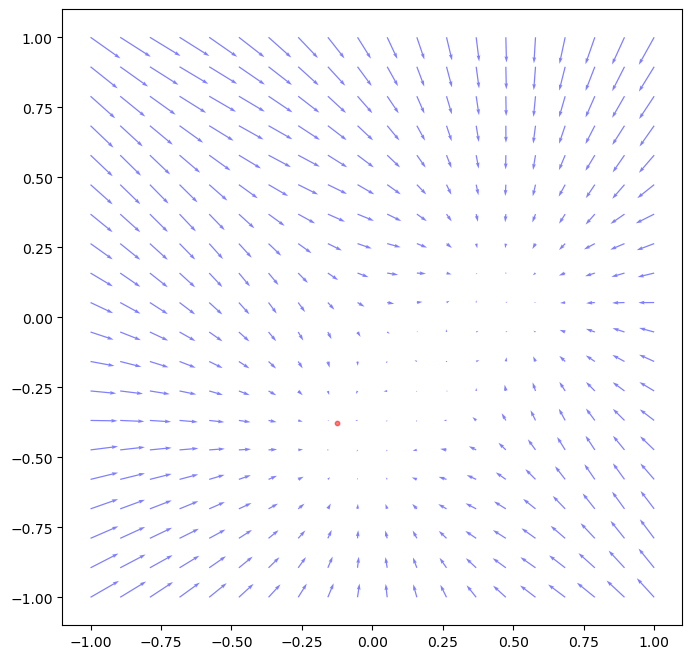

In [45]:
test_idx = np.random.randint(1000)

x_fid = x_test[test_idx]
fid_theta = thetas_test[test_idx]
fig,ax = plt.subplots(1,1,figsize=(8,8))
plot_range_x = all_prior[0]
plot_range_y = all_prior[1]
norm_vector = False

ax = plot_vector_field(plot_range_x,plot_range_y,
                  lambda theta: fm_regressor.cond_predict(x_fid,theta)*norm,
                  num_points=20,ax=ax,color='blue',alpha=0.5, label='regressor', width=0.002,norm_vector=norm_vector)
ax.scatter(
    fid_theta[0], fid_theta[1], label='theta_fid', alpha=0.5, s=10,color='red'
)

## Inference

Perform Bayesian inference assuming a flat prior (i.e., the prior score is zero). We use Hamiltonian Monte Carlo to sample from the posterior distribution.


In [38]:
from fsm.samplers import HamiltonianMonteCarloSampler

Choose a random mock observation

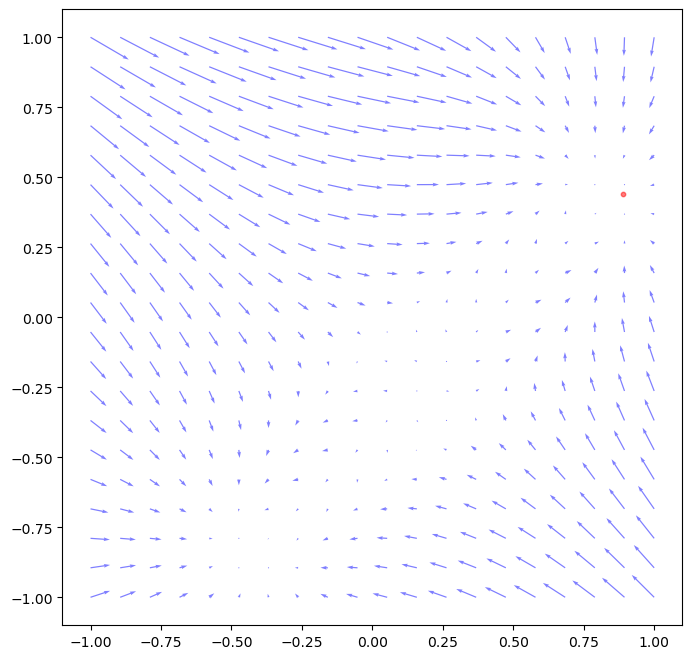

In [ ]:
test_idx = np.random.randint(1000)

x_fid = x_test[test_idx]
fid_theta = thetas_test[test_idx]
fig,ax = plt.subplots(1,1,figsize=(8,8))
plot_range_x = all_prior[0]
plot_range_y = all_prior[1]
norm_vector = False

ax = plot_vector_field(plot_range_x,plot_range_y,
                  lambda theta: fm_regressor.cond_predict(x_fid,theta)*norm,
                  num_points=20,ax=ax,color='blue',alpha=0.5, label='regressor', width=0.002,norm_vector=norm_vector)
ax.scatter(
    fid_theta[0], fid_theta[1], label='theta_fid', alpha=0.5, s=10,color='red'
)


Sample the posterior

In [28]:
score_func = lambda theta: (fm_regressor.cond_predict(x_fid,theta)*norm)[0]

In [39]:
sampler = HamiltonianMonteCarloSampler(score_func, momentum_cov=np.eye(2)*1e-1,prior=all_prior)
init_sample = np.array([[0.0, 0.0],[-0.1, -0.1]])
num_samples = 10000
samples, acceptance_rate,tracs = sampler.sample(
    num_samples=num_samples,
    initial_states=init_sample, 
    leapfrog_steps=10,
    leapfrog_step_size=1e-3,
    save_trajectory=True
)
print(f"Acceptance rate: {acceptance_rate}")

Acceptance rate: [0.9999 0.9999]


In [40]:
samples= samples.reshape(-1,2)

Plot the posterior, which accurately recovers the characteristic moon-shaped distribution.

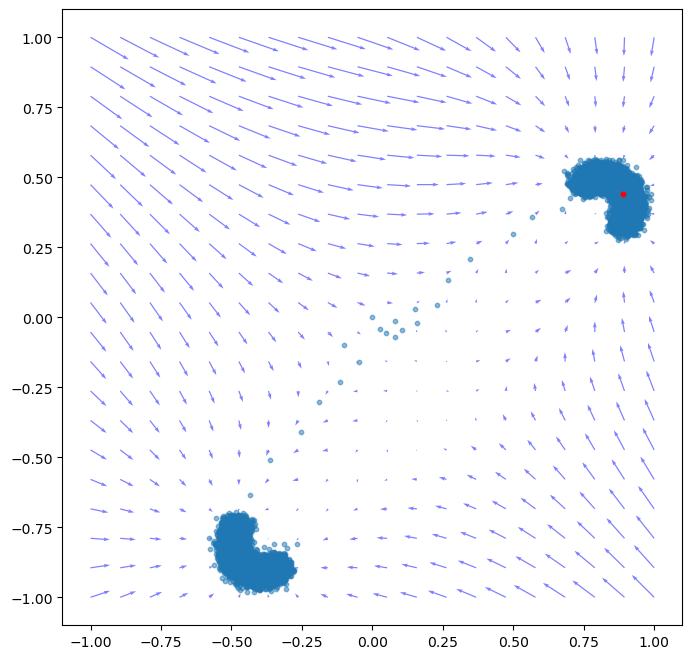

In [ ]:
x_fid = x_test[test_idx]
fid_theta = thetas_test[test_idx]
fig,ax = plt.subplots(1,1,figsize=(8,8))
plot_range_x = all_prior[0]
plot_range_y = all_prior[1]
norm_vector = False

ax = plot_vector_field(plot_range_x,plot_range_y,
                  lambda theta: fm_regressor.cond_predict(x_fid,theta)*norm,
                  num_points=20,ax=ax,color='blue',alpha=0.5, label='regressor', width=0.002,norm_vector=norm_vector)

plt.scatter(
    samples[:, 0], samples[:, 1], label='HMC samples', alpha=0.5, s=10
)

ax.scatter(
    fid_theta[0], fid_theta[1], label='theta_fid', alpha=1, s=10,color='red'
)